XML: ./data/C0048M01.XML
track.csv: ./data/C0048_track.csv
Capture FPS: 479.52
Format FPS: 29.97
playback_speed: 0.0625
frames: 213


/var/folders/fm/j5zsv9x1121cqbb30njg041r0000gn/T/ipykernel_33734/3250962498.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vid['Bx_vel'][0] = df_vid['Bx_vel'][1]
/var/folders/fm/j5zsv9x1121cqbb30njg041r0000gn/T/ipykernel_33734/3250962498.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vid['By_vel'][0] = df_vid['By_vel'][1]


,index,t,Ax,Ay,Bx,By,time,Bx_vel,By_vel,v_com
0,0,0.000000,0.154026,-0.044658,0.179691,-0.073385,0.000000,0.020523,0.054598,0.058328
1,1,0.033367,0.154080,-0.044602,0.179733,-0.073271,0.002085,0.020523,0.054598,0.058328
2,2,0.066733,0.154180,-0.044473,0.179780,-0.073155,0.004171,0.022058,0.055802,0.060003
3,3,0.100100,0.154254,-0.044301,0.179817,-0.072948,0.006256,0.017982,0.099174,0.100791
4,4,0.133467,0.154404,-0.043929,0.179821,-0.072799,0.008342,0.002158,0.071516,0.071548
...,...,...,...,...,...,...,...,...,...,...
208,208,6.940267,-0.083365,0.125459,-0.119520,0.137743,0.433767,-1.189726,-0.810382,1.439502
209,209,6.973633,-0.086050,0.123204,-0.121987,0.135998,0.435852,-1.182905,-0.836732,1.448925
210,210,7.007000,-0.088378,0.120900,-0.124407,0.134224,0.437937,-1.160428,-0.850373,1.438655
211,211,7.040367,-0.091000,0.118567,-0.126924,0.132380,0.440023,-1.206797,-0.884658,1.496322


t_dxl_start: 78.44
t_vid_liftoff: 0.1876875
t_force_liftoff: 4.920936
t_motor_start: 66.038
t_motor_end: 66.229
motoring time: 0.191
max_E_tot: 1.380


/var/folders/fm/j5zsv9x1121cqbb30njg041r0000gn/T/ipykernel_33734/3250962498.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vid['By_acc_filt'][0] = df_vid['By_acc_filt'][1]


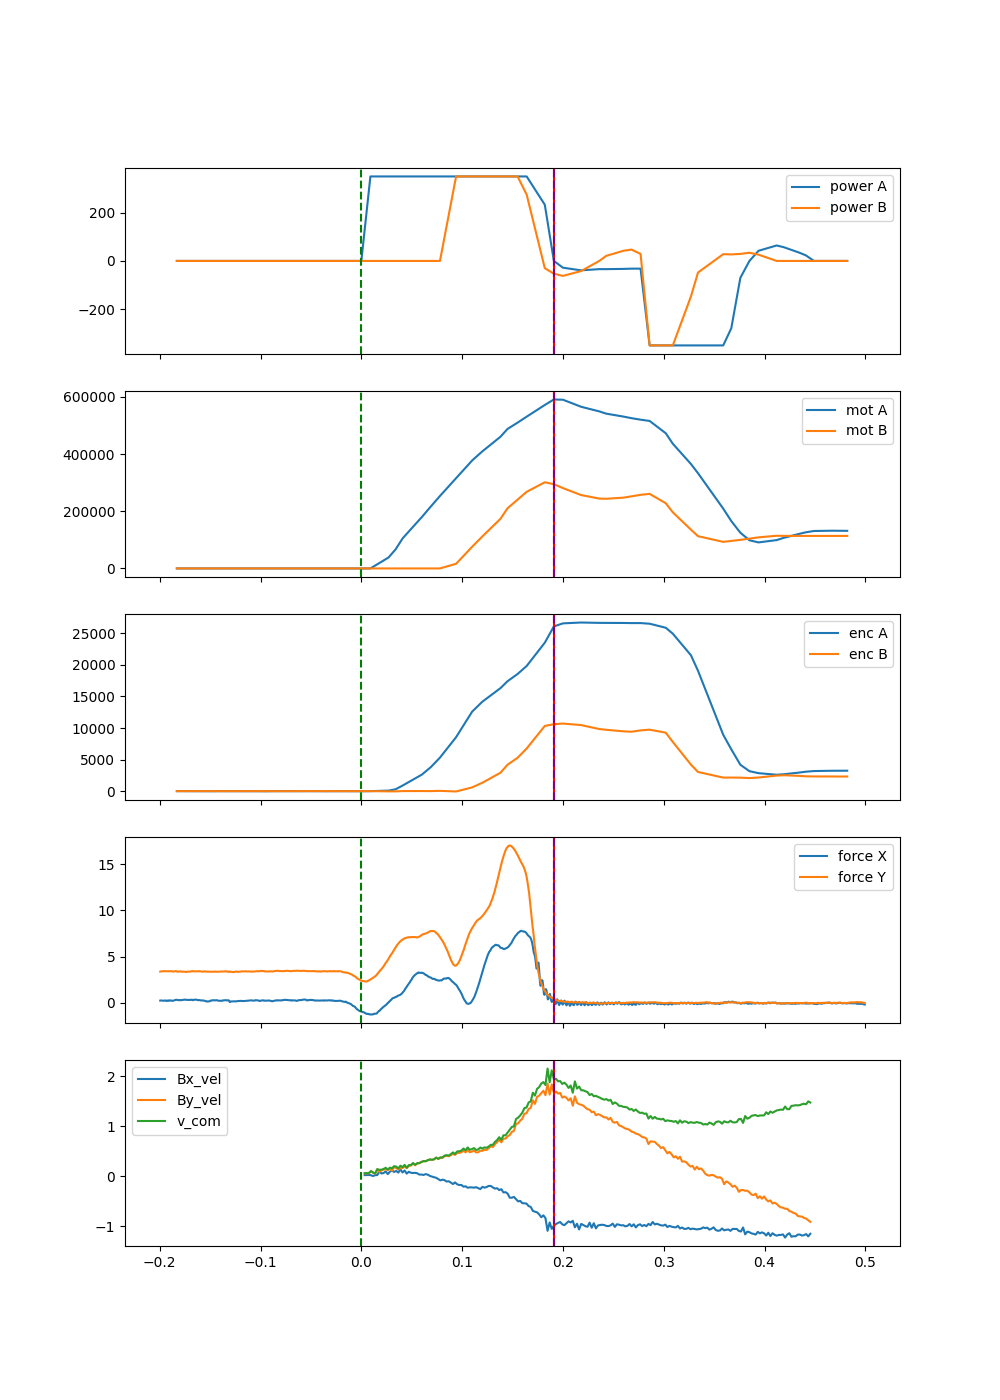

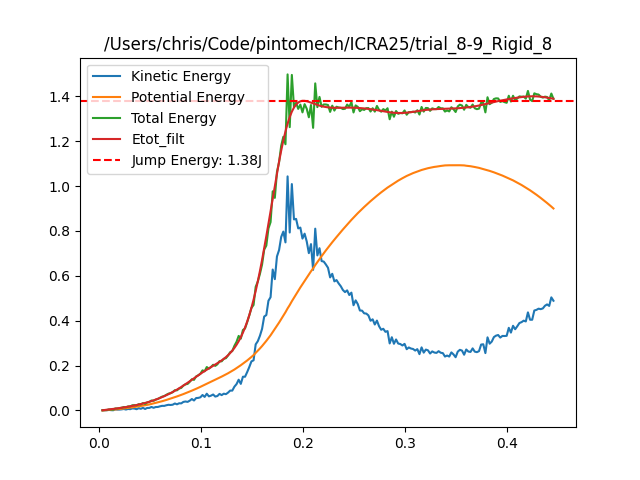

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import glob, os
import xml.etree.ElementTree as ET
%matplotlib widget

def butterworth_filter(data, cutoff, fs, order=3):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = signal.filtfilt(b, a, data)
    return filtered_data

def extract_from_txt(file_path, labels, delimiter='\n'):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    data_dict = {label: [] for label in labels}
    last_delimiter_index = 0
    messages = []
    for i in range(len(lines)):
        if(lines[i].startswith(delimiter)):
            messages.append(lines[last_delimiter_index:i])
            last_delimiter_index = i
    for message in messages:
        message_dict = {label: [] for label in labels}
        for label in labels:
            for line in message:
                    if(line.startswith(label)):
                        message_dict[label].append(float(line.split(':')[1]))
        full = True
        for key in message_dict:
            if(len(message_dict[key]) == 0):
                full=False
                break
        if(full):
            for label in labels:
                data_dict[label].append(message_dict[label][0])

    # for series in data_dict:
    #     print(series, len(data_dict[series]))

    df_raw = pd.DataFrame(data_dict)
    return df_raw

def remove_even_lines(input_file_path, output_file_path):
    with open(input_file_path, 'r') as file:
        lines = file.readlines()
    
    with open(output_file_path, 'w') as file:
        for i, line in enumerate(lines):
            if i % 2 == 0:
                file.write(line)

def extract_fps(xml_string):
    root = ET.fromstring(xml_string)
    video_frame = root.find('.//*[@captureFps][@formatFps]')
    if video_frame is not None:
        capture_fps = str(video_frame.get('captureFps'))
        format_fps = str(video_frame.get('formatFps'))
        return float(capture_fps[:-1]), float(format_fps[:-1])
    else:
        return np.nan, np.nan
    
encoder_file = max(glob.glob('./data/*encoder.txt'), key=os.path.getctime)
force_file = max(glob.glob('./data/*force.txt'), key=os.path.getctime)
track_file = max(glob.glob('./data/*track.csv'), key=os.path.getctime)
xml_file = max(glob.glob('./data/*.XML'), key=os.path.getctime)

df_log = extract_from_txt(
    encoder_file, 
    [
        't',
        'pA',
        'pB',
        'mA',
        'mB',
        'eA', 
        'eB', 
        'I',
        'd0',
        'd1',
        'd2',
        'd3',
        'd4',
    ],
    '#'
)

force_data_path = force_file[:-4] + '_filt.txt'
remove_even_lines(force_file, force_data_path)
df_force = extract_from_txt(
    force_data_path, 
    [
        'elapsed',
        'looptime',
        'N23', 
        'N67'
    ],
    '\n'
)

xml_content = open(xml_file, 'r').read()
capture_fps, format_fps = extract_fps(xml_content)
playback_speed = format_fps / capture_fps

print(f"XML: {xml_file}")
print(f"track.csv: {track_file}")
print(f"Capture FPS: {capture_fps}")
print(f"Format FPS: {format_fps}")
print(f"playback_speed: {playback_speed}")

df_vid = pd.read_csv(track_file)
df_vid = df_vid.dropna().reset_index()
print(f"frames: {len(df_vid)}")


df_log.loc[:,'time'] = df_log.loc[:,'t'] / 1e3
df_log['side_enc_pos'] = df_log['eA'] - df_log['eA'][0]
df_log['center_enc_pos'] = df_log['eB'] - df_log['eB'][0]
df_log['side_mot_pos'] = -(df_log['mA']-df_log['mA'][0])
df_log['center_mot_pos'] = -(df_log['mB']-df_log['mB'][0])
df_log['side_mot_pow'] = -df_log['pA']
df_log['center_mot_pow'] = -df_log['pB']

df_force.loc[:,'time'] = np.cumsum(df_force['looptime']) / 1e6
df_force['Fx'] = -(df_force['N23'] - df_force['N23'].iloc[-1])
df_force['Fy'] = df_force['N67'] - df_force['N67'].iloc[-1]

df_vid['time'] = df_vid['t'] * playback_speed
df_vid['Bx_vel'] = df_vid['Bx'].diff() / df_vid['time'].diff()
df_vid['By_vel'] = df_vid['By'].diff() / df_vid['time'].diff()
df_vid['Bx_vel'][0] = df_vid['Bx_vel'][1]
df_vid['By_vel'][0] = df_vid['By_vel'][1]
df_vid['v_com'] = np.linalg.norm([df_vid['Bx_vel'], df_vid['By_vel']], axis=0)
display(df_vid)


df_log['dv0'] = df_log['d0'].diff()/df_log['time'].diff()
i_log_dxl_start = df_log[df_log['dv0'] > 3000].index[0] - 1
# t_dxl_start = df_log['time'][i_log_dxl_start]
t_dxl_start = 78.44
print(f"t_dxl_start: {t_dxl_start}")

df_vid['By_vel_filt'] = butterworth_filter(df_vid['v_com'], 20, capture_fps)
df_vid['By_acc_filt'] = df_vid['By_vel_filt'].diff() / df_vid['time'].diff()
df_vid['By_acc_filt'][0] = df_vid['By_acc_filt'][1]

# i_vid_liftoff = np.where(np.diff(np.sign(df_vid['By_acc_filt'])))[0][-1]
i_vid_liftoff = df_vid['By_vel_filt'].loc[df_vid['By_vel'] > 0].idxmax()
t_vid_liftoff = df_vid['time'][i_vid_liftoff]
print(f"t_vid_liftoff: {t_vid_liftoff}")

df_force['net_force'] = np.sqrt(df_force['Fx']**2 + df_force['Fy']**2)
i_force_liftoff = df_force[df_force['net_force'] > 0.5].index[-1]
t_force_liftoff = df_force['time'][i_force_liftoff]
print(f"t_force_liftoff: {t_force_liftoff}")

i_motorstart = df_log[df_log['side_mot_pow'] > 349].index[0] - 1
t_motor_start = df_log['time'][i_motorstart]
print(f"t_motor_start: {t_motor_start}")

df_log = df_log[df_log['time'] < t_motor_start + 0.55]

side_enc_thres = max(df_log['side_enc_pos']) - 1000
i_motor_end = df_log[df_log['side_enc_pos'] > side_enc_thres].index[0]
t_motor_end = df_log['time'][i_motor_end]
print(f"t_motor_end: {t_motor_end}")


# synchronize df_log, df_force, and df_vid on the liftoff/motor_end time, but set the zero to t_dxl_start
df_log.loc[:,'time'] = df_log.loc[:,'time'] - t_motor_start

offset_force_log = t_force_liftoff - t_motor_end
df_force.loc[:,'time'] = df_force.loc[:,'time'] - t_motor_start - offset_force_log
t_force_liftoff = t_motor_end - t_motor_start

offset_vid_log = t_vid_liftoff - t_motor_end
df_vid.loc[:,'time'] = df_vid.loc[:,'time'] - t_motor_start - offset_vid_log
t_vid_liftoff = t_motor_end - t_motor_start

t_motor_end = t_motor_end - t_motor_start
t_motor_start = 0

time_before = 0.2
time_after = 0.5
df_log = df_log[df_log['time'] >  - time_before]
df_log = df_log[df_log['time'] <  + time_after]
df_log = df_log.reset_index()
df_force = df_force[df_force['time'] >  - time_before]
df_force = df_force[df_force['time'] <  + time_after]
df_force = df_force.reset_index()
df_vid = df_vid[df_vid['time'] >  - time_before]
df_vid = df_vid[df_vid['time'] <  + time_after]
df_vid = df_vid.reset_index()



#rezero after the time range
df_log['side_enc_pos'] = df_log['eA'] - df_log['eA'][0]
df_log['center_enc_pos'] = df_log['eB'] - df_log['eB'][0]
df_log['side_mot_pos'] = -(df_log['mA']-df_log['mA'][0])
df_log['center_mot_pos'] = -(df_log['mB']-df_log['mB'][0])

fig, axs = plt.subplots(5,1,figsize=(10,14), sharex=True)
axs[0].plot(df_log['time'], df_log['side_mot_pow'], label='power A')
axs[0].plot(df_log['time'], df_log['center_mot_pow'], label='power B')
axs[1].plot(df_log['time'], df_log['side_mot_pos'], label='mot A')
axs[1].plot(df_log['time'], df_log['center_mot_pos'], label='mot B')


# axs[2].plot(df_log['time'], df_log['side_enc_pos'].diff() / df_log['time'].diff(), label='enc A')
axs[2].plot(df_log['time'], df_log['side_enc_pos'], label='enc A')
axs[2].plot(df_log['time'], df_log['center_enc_pos'], label='enc B')


axs[3].plot(df_force['time'], df_force['Fx'], label='force X')
axs[3].plot(df_force['time'], df_force['Fy'], label='force Y')
axs[4].plot(df_vid['time'], df_vid['Bx_vel'], label='Bx_vel')
axs[4].plot(df_vid['time'], df_vid['By_vel'], label='By_vel')
axs[4].plot(df_vid['time'], df_vid['v_com'], label='v_com')
for ax in axs:
    ax.legend()
    ax.axvline(x=t_motor_start, color='g', linestyle='--')
    ax.axvline(x=t_force_liftoff, color='r', linestyle='-')
    ax.axvline(x=t_motor_end, color='purple', linestyle='--')

print(f"motoring time: {t_motor_end - t_motor_start:.3f}")


m = 0.450
g = 9.81

KE = 0.5*m*df_vid['v_com']**2
PE = m*g*(df_vid['By'] - df_vid['By'][0])
PE.loc[PE < 0] = 0
E_tot = KE + PE
df_vid['E_tot_filt'] = butterworth_filter(E_tot, 20, capture_fps)

max_E_tot = max(df_vid['E_tot_filt'].loc[df_vid['By_vel'] > 0])
print(f"max_E_tot: {max_E_tot:.3f}")
# v_com

plt.figure()
directory_name = os.path.abspath("")
plt.title(directory_name)
plt.plot(df_vid['time'], KE, label='Kinetic Energy')
plt.plot(df_vid['time'], PE, label='Potential Energy')
plt.plot(df_vid['time'], E_tot, label='Total Energy')
plt.plot(df_vid['time'], df_vid['E_tot_filt'], label='Etot_filt')
plt.axhline(y=max_E_tot, color='r', linestyle='--', label=f'Jump Energy: {max_E_tot:.3}J')
plt.legend()




In [15]:
df_vid

,level_0,index,t,Ax,Ay,Bx,By,time,Bx_vel,By_vel,v_com,By_vel_filt,By_acc_filt,E_tot_filt
0,0,0,0.000000,0.154026,-0.044658,0.179691,-0.073385,0.003313,0.020523,0.054598,0.058328,0.058177,4.303819,0.000577
1,1,1,0.033367,0.154080,-0.044602,0.179733,-0.073271,0.005398,0.020523,0.054598,0.058328,0.067152,4.303819,0.001738
2,2,2,0.066733,0.154180,-0.044473,0.179780,-0.073155,0.007483,0.022058,0.055802,0.060003,0.076073,4.277879,0.002901
3,3,3,0.100100,0.154254,-0.044301,0.179817,-0.072948,0.009569,0.017982,0.099174,0.100791,0.084936,4.249880,0.004075
4,4,4,0.133467,0.154404,-0.043929,0.179821,-0.072799,0.011654,0.002158,0.071516,0.071548,0.093728,4.216244,0.005271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,208,208,6.940267,-0.083365,0.125459,-0.119520,0.137743,0.437079,-1.189726,-0.810382,1.439502,1.441840,4.982476,1.395560
209,209,209,6.973633,-0.086050,0.123204,-0.121987,0.135998,0.439165,-1.182905,-0.836732,1.448925,1.451819,4.784938,1.394042
210,210,210,7.007000,-0.088378,0.120900,-0.124407,0.134224,0.441250,-1.160428,-0.850373,1.438655,1.461304,4.548255,1.392410
211,211,211,7.040367,-0.091000,0.118567,-0.126924,0.132380,0.443335,-1.206797,-0.884658,1.496322,1.470209,4.270131,1.390722
